In [1]:
# https://mail.google.com/mail/u/0/#inbox/QgrcJHrnscJGjsRzFLPzmGMZSlGWKMsntRB

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from childes_mi.utils.paths import DATA_DIR, ensure_dir, DROSOPHILA_DIR
import urllib.request

In [4]:
from tqdm.autonotebook import tqdm
import h5py
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
mat_file = list(DROSOPHILA_DIR.glob('*.mat'))[0]
mat_file

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/data/raw/DROSOPHILA_Data_Dir/transition_data.mat')

In [6]:
ds = scipy.io.loadmat(mat_file.as_posix())

In [7]:
ds.keys()

dict_keys(['__header__', '__version__', '__globals__', 'density', 'transition_states', 'xx', 'peakPoints', 'regionMap'])

In [8]:
ds['transition_states'][0]

array([array([[59],
       [43],
       [11],
       ...,
       [43],
       [40],
       [44]], dtype=uint8)], dtype=object)

In [9]:
states = [np.concatenate(np.concatenate(i)) for i in ds['transition_states']]

In [10]:
states[0]

array([59, 43, 11, ..., 43, 40, 44], dtype=uint8)

In [11]:
len(states[0])

10803

In [12]:
state_lens = [len(i) for i in states]

(array([ 3.,  1.,  6.,  8., 18., 11.,  8.,  3.,  0.,  1.]),
 array([ 7447. ,  8181.3,  8915.6,  9649.9, 10384.2, 11118.5, 11852.8,
        12587.1, 13321.4, 14055.7, 14790. ]),
 <a list of 10 Patch objects>)

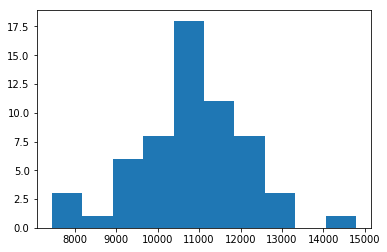

In [13]:
plt.hist(state_lens)

### Mutual information

In [14]:
from childes_mi.information_theory import mutual_information as mi

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.supervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.expected_mutual_info_fast module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [15]:
distances = np.arange(1,1001)

In [17]:
MI_DF_list = []
for sti, state in enumerate(tqdm(states)):
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        [state], distances=distances, n_jobs=-1, verbosity=0
    )
    MI_DF = pd.DataFrame(
        [[MI, MI_var, shuff_MI, shuff_MI_var, distances]],
        columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances"],
    )
    MI_DF_list.append(MI_DF)
MI_DF = pd.concat(MI_DF_list)

In [18]:
MI_DF.to_pickle(DATA_DIR / "mi" / "drosophila_mi_1000_indv_MI.pickle")

### individual behavioral sequences

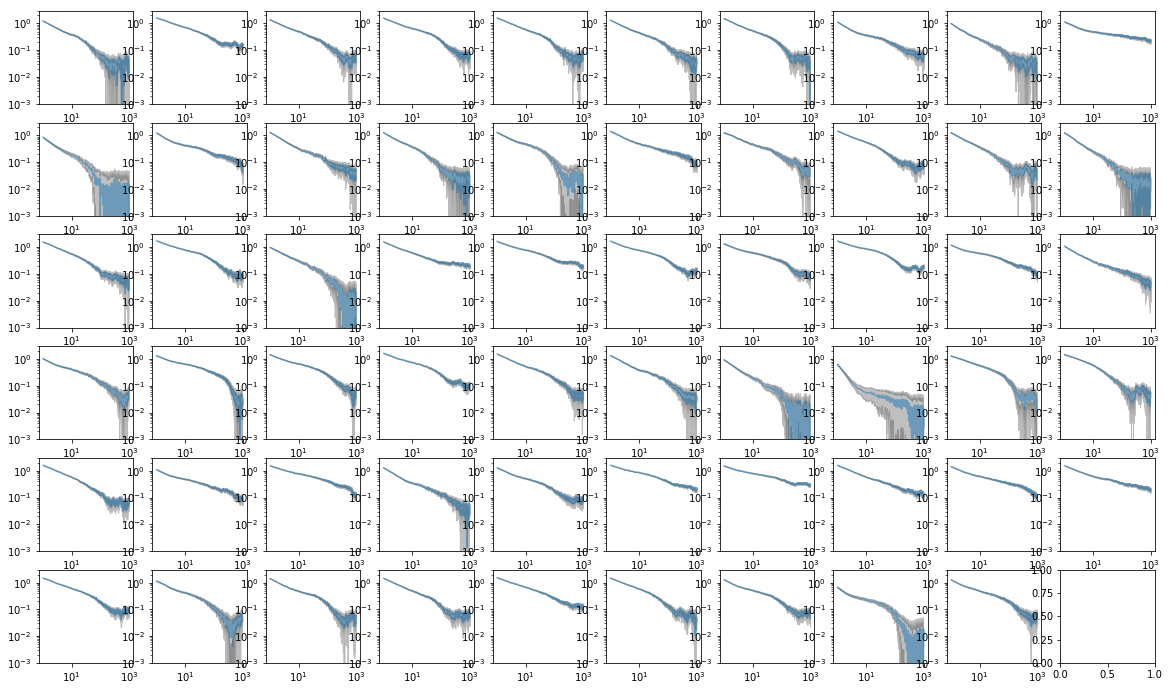

In [19]:
fig, axs = plt.subplots(ncols = 10, nrows=6, figsize = (20,12))
for ri, (idx, row) in tqdm(enumerate(MI_DF.iterrows())):
    ax = axs.flatten()[ri]
    MI = row.MI-row.shuff_MI
    MI_var = row.MI_var

    ax.plot(distances, MI, alpha=0.5)
    ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
    ax.set_ylim([1e-3, 3])
    ax.set_yscale('log')
    ax.set_xscale('log')

### fit data

In [26]:
from childes_mi.information_theory import model_fitting as mf

In [27]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [28]:
MI_DF = MI_DF.reset_index()

In [29]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)

    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    min_peak = np.nan
    
    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel',  'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        min_peak
    ]

/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/childes_mi/information_theory/model_fitting.py:8: RuntimeWarning: invalid value encountered in log
  return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))


In [30]:
MI_DF[:3]

,level_0,index,MI,MI_var,shuff_MI,shuff_MI_var,distances,exp_results,pow_results,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,0,0,"[5.547644303516421, 5.151395445282732, 4.97493...","[0.02298543805034415, 0.02246780300715515, 0.0...","[4.312541772593027, 4.318859649112234, 4.31125...","[0.021632813835745168, 0.021642066139425625, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.924729,0.944300,0.910465,-5395.074925,-5691.539734,-5221.877775,pow_exp,NaN,NaN
1,1,0,"[5.917134261807169, 5.578157695490129, 5.36517...","[0.02375456253385853, 0.023218822033943185, 0....","[4.280626348630385, 4.292514599673648, 4.28382...","[0.02217176473463562, 0.022213440867278035, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.959237,0.986218,0.975633,-6936.626648,-8016.963185,-7451.171391,pow_exp,NaN,NaN
2,2,0,"[5.676969883808944, 5.2946366948922385, 5.1173...","[0.023592483607056836, 0.023127531399205075, 0...","[4.315023125345027, 4.318203875880924, 4.32133...","[0.022364471711603703, 0.02235866660882637, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.939278,0.975782,0.954921,-5855.014540,-6770.170175,-6152.896758,pow_exp,NaN,NaN


### plot fits

In [31]:
from matplotlib import gridspec

In [36]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig

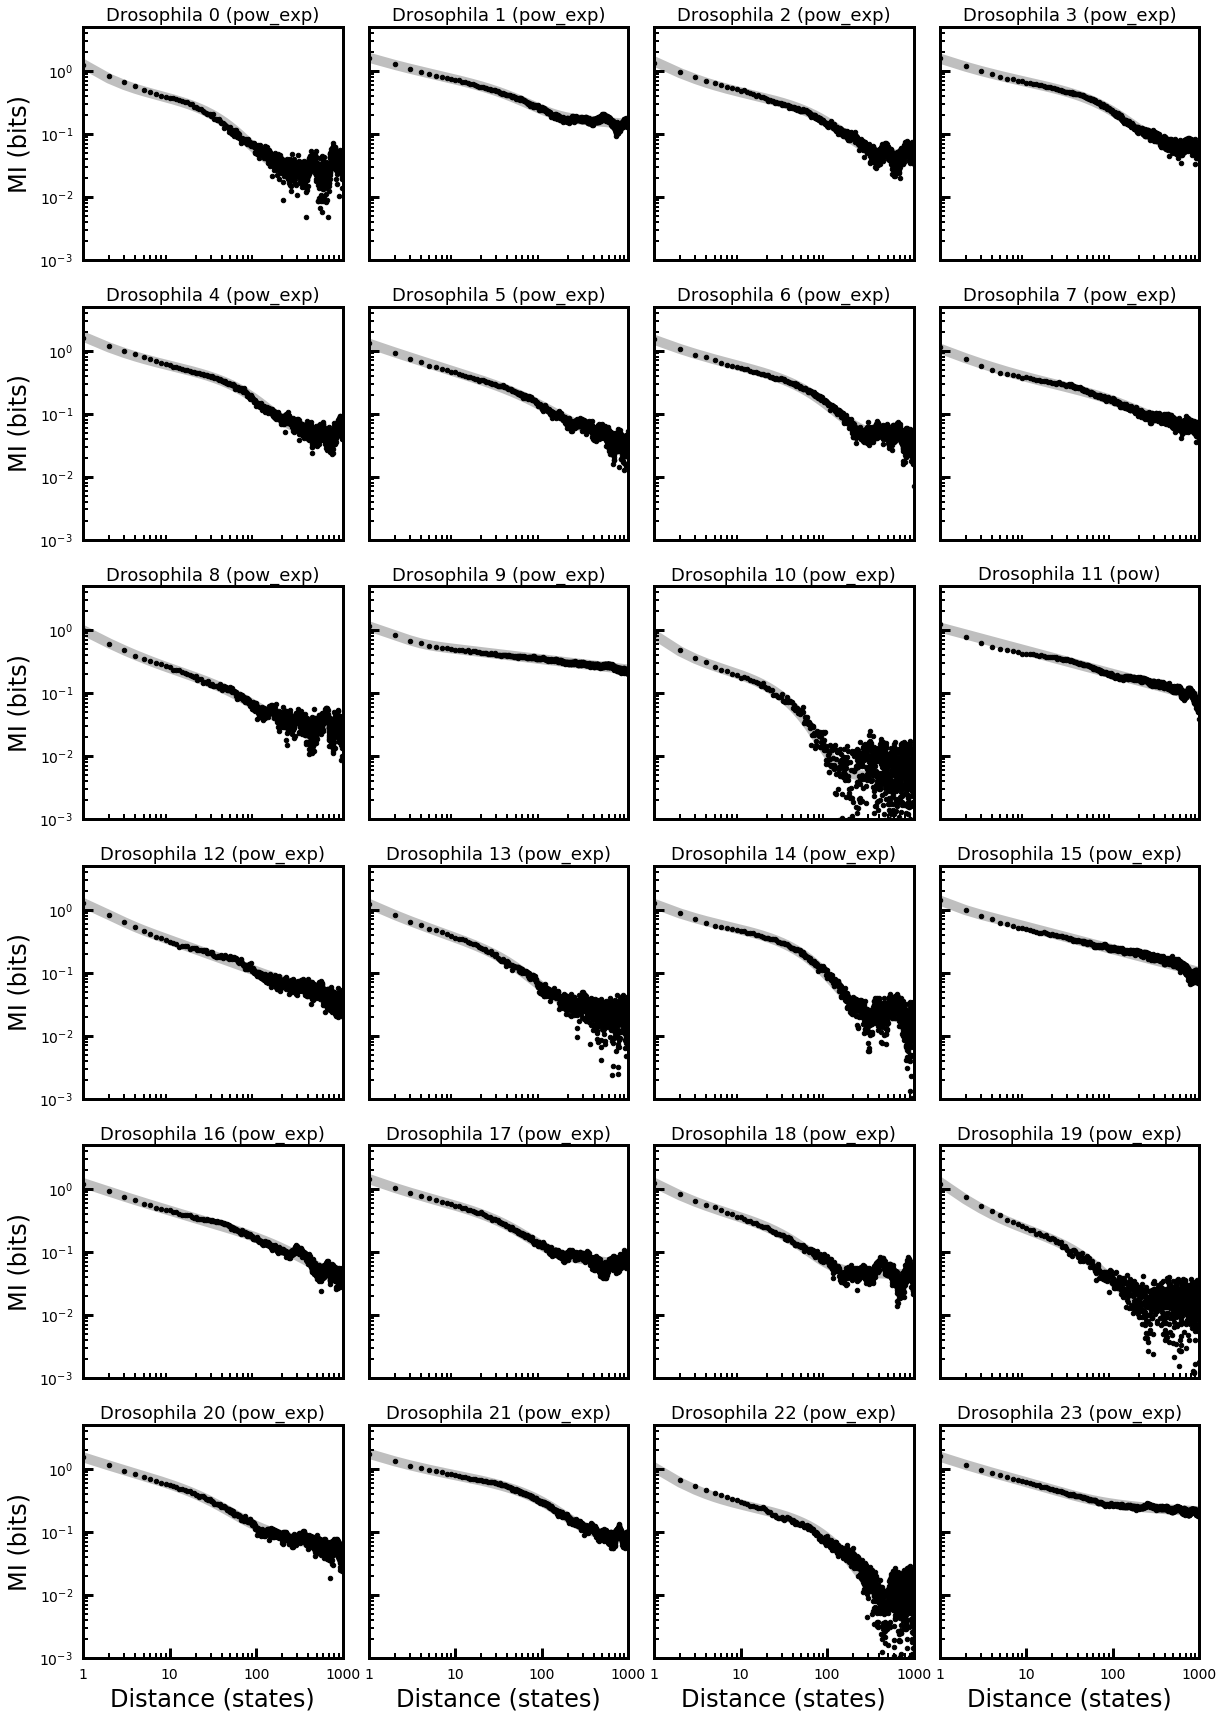

In [41]:
ncols = 4
nrows = 6
yoff=-.20

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 30))
for axi, (idx, row) in enumerate(MI_DF[:nrows*ncols].iterrows()):
    ax = axs.flatten()[axi]

    color = "k"
    sig = np.array(row.MI - row.shuff_MI)
    distances = row.distances

    sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
    sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                    sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]


    if axi in [ncols*i for i in range(nrows)]:
        ax.set_ylabel("MI (bits)", labelpad=5, fontsize=24)
        ax.yaxis.set_label_coords(yoff, 0.5)

    distances_model = np.logspace(0, np.log10(distances[-1]), base=10, num=1000)

    # plot real data
    ax.scatter(distances, sig, alpha=1, s=20, color=color)
    #print(idx)
    if row.bestfitmodel == "pow_exp":
        y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances)

    elif row.bestfitmodel == "exp":
        y_model = mf.get_y(mf.exp_decay, row.exp_results, distances)

    elif row.bestfitmodel == "pow":
        y_model = mf.get_y(mf.powerlaw_decay, row.pow_results, distances)

    #print(y_model[:3])
    # plot modelled data
    ax.plot(distances, y_model, alpha=0.25, lw=10, color=color)

    ax.set_title("Drosophila {} ({})".format(axi, row.bestfitmodel), fontsize=18)
    ax.set_xlim([distances[0], distances[-1]])
    sig_lims[0] = np.log(10e-6)  #
    ax.set_ylim([1e-3, 5])
    ax.tick_params(which="both", direction="in", labelsize=14, pad=10)
    ax.tick_params(which="major", length=10, width=3)
    ax.tick_params(which="minor", length=5, width=2)
    ax.set_xscale("log", basex=10)
    ax.set_yscale("log", basey=10)
    ax.set_xticks([])
    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(3)
        ax.spines[axis].set_color("k")

    if axi in range(nrows*ncols - ncols, nrows*ncols):
        ax.set_xticks([1,10,100, 1000])
        ax.set_xticklabels(['1','10','100', '1000'])
        ax.set_xlabel("Distance (states)", labelpad=5, fontsize=24)

    if axi not in [ncols*i for i in range(nrows)]:
        ax.set_yticklabels([])

    fig.subplots_adjust(wspace = 0.1)

ensure_dir(FIGURE_DIR/ 'mi' / 'indv')
save_fig(FIGURE_DIR/ 'mi' / 'indv' /('drosophila_mi_individual'))
plt.show()